In [3]:
# from pyspark import SparkContext 
# from pyspark.sql import SQLContext 
import pandas as pd
import numpy as np
# from pandas import DataFrame
# sc = SparkContext.getOrCreate()
# sqlc=SQLContext(sc)

import math
import matplotlib.pyplot as plt
from scipy.stats import norm, entropy 
from scipy.stats import probplot
import matplotlib.pyplot as plt
from scipy.stats import logistic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import resample
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from scipy.spatial.distance import cosine, correlation
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Perceptron

In [4]:
#reading csv file data in a dataframe
#[1]https://stackoverflow.com/questions/46311133/creating-dynamic-data-frames-in-python?rq=1
df_names=['df07','df08','df09','df10','df11','df12','df13','df14','df15','df16','df17','df18']
years=['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
d = {}
for name,i in zip(df_names,years):
    d[name] = pd.DataFrame()
    d[name]=pd.read_csv('data-csv/chs'+str(i)+'_public.csv')    


In [5]:
# df=df18.copy()
df=d['df15']
df.head()

,mood1,mood2,mood3,mood4,mood5,mood6,mood24,mood53,mood52,mood11,...,nycdriver,drivefreq,drivefreq_all,drivefreq3_all,everspeed,speedfreq,evermessage,messagefreq,hhsize,child
0,5,5,5,5,5,4,NaN,NaN,NaN,2.0,...,2.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,2,2.0
1,5,5,5,5,5,5,NaN,NaN,NaN,2.0,...,1.0,4.0,5.0,2.0,2.0,4.0,2.0,4.0,4,2.0
2,5,3,5,4,2,4,NaN,NaN,NaN,2.0,...,2.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1,2.0
3,4,5,5,5,5,5,NaN,NaN,NaN,2.0,...,2.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1,2.0
4,5,5,4,5,5,5,NaN,NaN,NaN,2.0,...,1.0,5.0,6.0,3.0,1.0,3.0,2.0,4.0,4,1.0


In [6]:
#number of features
len(df.columns)

147

In [7]:
df.columns

Index(['mood1', 'mood2', 'mood3', 'mood4', 'mood5', 'mood6', 'mood24',
       'mood53', 'mood52', 'mood11',
       ...
       'nycdriver', 'drivefreq', 'drivefreq_all', 'drivefreq3_all',
       'everspeed', 'speedfreq', 'evermessage', 'messagefreq', 'hhsize',
       'child'],
      dtype='object', length=147)

In [8]:
#number of rows
len(df["mood1"])

10172

In [9]:
df.isnull().sum()

mood1             0
mood2             0
mood3             0
mood4             0
mood5             0
               ... 
speedfreq      5995
evermessage    5965
messagefreq    5965
hhsize            0
child            32
Length: 147, dtype: int64

qxvers-Questionnaire version
nutrition46-cupsof fruit
nutrition47-cups of vegetable

# Steps followed for analysis
#process NA values
#find correlation between target and source variables and perform dimensionality reduction
#divide data into training and test sets
#apply regression
#reduce parameters depending upon correlartion
#apply regression again and compare models

In [10]:
#correlation function
#[1]https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
#[2]https://seaborn.pydata.org/examples/many_pairwise_correlations.html
def draw_corr(corr_var):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_var, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(
        corr_var, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        mask=mask,
#         annot=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

# Checking correlation between physical activity data

In [11]:
df_train_physical=df[["cid","exercise15","generalhealth"]]

In [12]:
df_train_physical.isnull().sum()

cid               0
exercise15       12
generalhealth    68
dtype: int64

In [13]:
# #since imputed_PA08_3R_q1 has 5000+ values as N/A we will drop this column
# df_train_physical=df_train_physical[["cid","exercise116","cyclingfreq","cycling17","generalhealth"]]
# df_train_physical.head()

In [14]:
#dropping NaN values
df_train_physical=df_train_physical.dropna()
df_train_physical.head()

,cid,exercise15,generalhealth
0,1600001,1.0,2.0
1,1600002,1.0,3.0
2,1600003,2.0,4.0
3,1600004,1.0,2.0
4,1600005,1.0,1.0


In [15]:
#correlation
#[1]https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
corr_1 = df_train_physical.corr()
corr_1

,cid,exercise15,generalhealth
cid,1.000000,-0.002788,-0.075913
exercise15,-0.002788,1.000000,0.205517
generalhealth,-0.075913,0.205517,1.000000


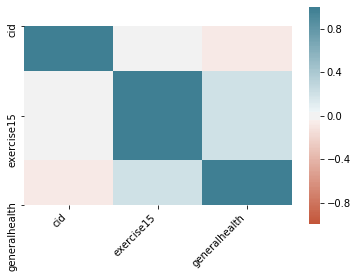

In [16]:
ax = sns.heatmap(
    corr_1, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#we see that there is not much correlation among variables

In [17]:
# df_train_physical=df_train_physical[["cid","exercise17","cyclingfreq","generalhealth"]]
# df_train_physical.head()

In [18]:
# corr_2 = df_train_physical[["exercise17","cyclingfreq","generalhealth"]].corr()
# draw_corr(corr_2)
# print(corr_2)
# #All have positive correlation. exercise18 is most correlated to general health

# Checking correlation between Nutrition data

In [19]:
df_train_nutrition = df[["fruitveg",
                         "nsodaperday15","avgsodaperday15","twoplussoda",
                         "nsugardrinkperday15","avgsugarperday15","nsodasugarperday15",
                         "ssb",
                         "generalhealth"]]
print(df_train_nutrition.head())
df_train_nutrition.isnull().sum()


   fruitveg  nsodaperday15  avgsodaperday15  twoplussoda  nsugardrinkperday15  \
0       2.0            3.0              4.0          1.0             2.000000   
1       2.0            0.0              1.0          2.0             0.000000   
2       2.0            0.0              1.0          2.0             0.142857   
3       2.0            0.0              1.0          2.0             1.000000   
4       2.0            2.0              4.0          1.0             0.000000   

   avgsugarperday15  nsodasugarperday15  ssb  generalhealth  
0               4.0            5.000000  1.0            2.0  
1               1.0            0.000000  2.0            3.0  
2               2.0            0.142857  2.0            4.0  
3               3.0            1.000000  1.0            2.0  
4               1.0            2.000000  1.0            1.0  


fruitveg               275
nsodaperday15           82
avgsodaperday15         82
twoplussoda             82
nsugardrinkperday15    100
avgsugarperday15       100
nsodasugarperday15     111
ssb                    111
generalhealth           68
dtype: int64

generalhealth     avgsugarperday15    0.008740
avgsugarperday15  generalhealth       0.008740
generalhealth     avgsodaperday15     0.008747
avgsodaperday15   generalhealth       0.008747
nsodaperday15     generalhealth       0.009968
                                        ...   
twoplussoda       twoplussoda         1.000000
avgsodaperday15   avgsodaperday15     1.000000
nsodaperday15     nsodaperday15       1.000000
ssb               ssb                 1.000000
generalhealth     generalhealth       1.000000
Length: 81, dtype: float64

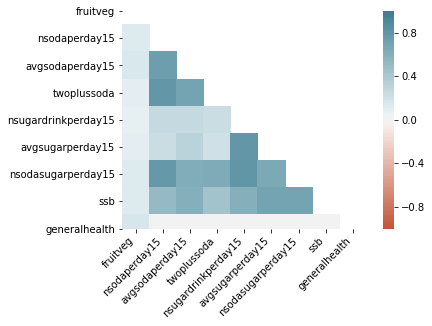

In [20]:
#[1]https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

df_train_nutrition=df_train_nutrition.dropna()
corr_3 = df_train_nutrition.corr().abs()
draw_corr(corr_3)

corr_3.unstack().sort_values(kind="quicksort")


generalhealth       avgsugarperday15      0.008740
avgsugarperday15    generalhealth         0.008740
generalhealth       avgsodaperday15       0.008747
avgsodaperday15     generalhealth         0.008747
generalhealth       nsodasugarperday15    0.015281
nsodasugarperday15  generalhealth         0.015281
ssb                 generalhealth         0.034672
generalhealth       ssb                   0.034672
avgsodaperday15     avgsugarperday15      0.327165
avgsugarperday15    avgsodaperday15       0.327165
ssb                 avgsodaperday15       0.607082
avgsodaperday15     ssb                   0.607082
nsodasugarperday15  avgsodaperday15       0.631345
avgsodaperday15     nsodasugarperday15    0.631345
avgsugarperday15    nsodasugarperday15    0.648968
nsodasugarperday15  avgsugarperday15      0.648968
ssb                 avgsugarperday15      0.702702
avgsugarperday15    ssb                   0.702702
ssb                 nsodasugarperday15    0.704397
nsodasugarperday15  ssb        

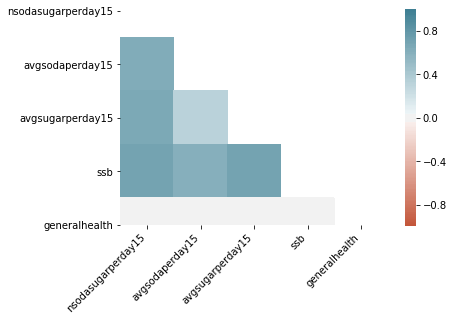

In [21]:
# features dropped pertaining to high correlation with other features :  
df_train_nutrition = df_train_nutrition[["nsodasugarperday15",
                        "avgsodaperday15"
                        ,"avgsugarperday15"
                         ,"ssb"
                         ,"generalhealth"]]

#finding correlation in remaining features
corr_nutrition = df_train_nutrition.corr().abs()
draw_corr(corr_nutrition)
corr_nutrition.unstack().sort_values(kind="quicksort")


#Next most correlated columns after deleting the previous coulmns:

nutrition47       fruitveg18          0.597664
fruitveg18        nutrition46         0.624137
avgsodaperday18   ssb                 0.626788

ssb               avgsugarperday18   -0.687271

ssb is correlated to both avgsodaperday18 and avgsugarperday18. We will keep ssb as it combines both soda and other drinks consumed by an individual. Also nutrition47 and fruitveg18 are correlated. Lets keep them for now as corelation is not very strong.

In [22]:
# features dropped pertaining to high correlation with other features :  
df_train_nutrition = df_train_nutrition[[
                         "ssb"
                         ,"generalhealth"]]

# Making prediction and checking rmse

In [23]:
#[1]https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
#[2]https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#[3]https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
#[4]https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from math import sqrt

#function for rmse calculation of model
def model_apply(x,y,algo,n):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=0)
    scaler = StandardScaler()
    # Fit on training set only.
    scaler.fit(x_train)
    # Apply transform to both the training set and the test set.
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    pca = PCA(n_components=n,tol=.95)
    pca.fit(x_test)
    print(pca.explained_variance_ratio_) 
    
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)
    
#     principalDf = pd.DataFrame(data = x_train
#              , columns = ['pc1', 'pc2','pc3'])
#     print(principalDf)

    #model selection
    if algo==1:
        model=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=200)
    elif algo==2:
        model=GaussianNB()
    elif algo==3:
        model=DecisionTreeClassifier()
    elif algo==4:
        model=svm.SVC(gamma='scale')
    elif algo==5:
        model=Perceptron(tol=1e-3, random_state=0)
        
        # Train the model using the training sets
    model.fit(x_train,y_train.values.ravel())

    # Predict Output
    y_pred = model.predict(x_test)
    print ("Predicted Value:", y_pred)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    return(rmse)

# Physical Activity vs General Health

In [24]:
#preparing training and test data
x=df_train_physical[["exercise15"]] #source feature
y=df_train_physical[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1841
# model = GaussianNB() #rmse=1.28

In [26]:
model_apply(x,y,3,1)

[1.]
Predicted Value: [3. 3. 3. ... 3. 3. 3.]
Accuracy: 0.31576862123613314
[[  0   0 429   0   0]
 [  0   0 657   0   0]
 [  0   0 797   0   0]
 [  0   0 466   0   0]
 [  0   0 175   0   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       429
         2.0       0.00      0.00      0.00       657
         3.0       0.32      1.00      0.48       797
         4.0       0.00      0.00      0.00       466
         5.0       0.00      0.00      0.00       175

    accuracy                           0.32      2524
   macro avg       0.06      0.20      0.10      2524
weighted avg       0.10      0.32      0.15      2524



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1841196988365414

# Nutrition vs General Health

In [24]:
#preparing training and test data
x=df_train_nutrition[["ssb"]] #source feature
y=df_train_nutrition[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1545
# model = GaussianNB() #rmse=1.28
model_apply(x,y,1,1)

('Predicted Value:', array([3., 3., 3., ..., 3., 3., 3.]))
('Accuracy:', 0.3257825370675453)
[[  0   0 358   0   0]
 [  0   0 673   0   0]
 [  0   0 791   0   0]
 [  0   0 431   0   0]
 [  0   0 175   0   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       358
         2.0       0.00      0.00      0.00       673
         3.0       0.33      1.00      0.49       791
         4.0       0.00      0.00      0.00       431
         5.0       0.00      0.00      0.00       175

   micro avg       0.33      0.33      0.33      2428
   macro avg       0.07      0.20      0.10      2428
weighted avg       0.11      0.33      0.16      2428

1.15446272548


# Checking correlation between CardioVascular Health data

In [27]:
df_train_cardio=df[["toldhighbp15","toldprescription15","takingmeds15","generalhealth"]]
print(df_train_cardio.head())
df_train_cardio.isnull().sum()

   toldhighbp15  toldprescription15  takingmeds15  generalhealth
0           2.0                 NaN           NaN            2.0
1           2.0                 NaN           NaN            3.0
2           1.0                 1.0           1.0            4.0
3           1.0                 1.0           1.0            2.0
4           2.0                 NaN           NaN            1.0


toldhighbp15            43
toldprescription15    6696
takingmeds15          7032
generalhealth           68
dtype: int64

toldprescription16 and takingmeds15 has high NA values so we have to drop them from dataset

In [28]:
df_train_cardio=df[["toldhighbp15","generalhealth"]]
print(df_train_cardio.head())
df_train_cardio.isnull().sum()

   toldhighbp15  generalhealth
0           2.0            2.0
1           2.0            3.0
2           1.0            4.0
3           1.0            2.0
4           2.0            1.0


toldhighbp15     43
generalhealth    68
dtype: int64

toldhighbp15   generalhealth    0.317044
generalhealth  toldhighbp15     0.317044
toldhighbp15   toldhighbp15     1.000000
generalhealth  generalhealth    1.000000
dtype: float64

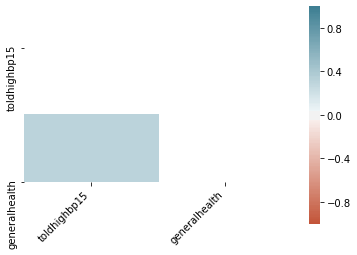

In [29]:
df_train_cardio=df_train_cardio.dropna()
corr_cardio = df_train_cardio.corr().abs()
draw_corr(corr_cardio)
corr_cardio.unstack().sort_values(kind="quicksort")

# Cardio vs General Health


In [30]:
df_train_cardio=df_train_cardio[["toldhighbp15","generalhealth"]]
df_train_cardio=df_train_cardio.dropna()
#preparing training and test data
x=df_train_cardio[["toldhighbp15"]] #source feature
y=df_train_cardio[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1760
# model = GaussianNB() #rmse=1.28
model_apply(x,y,1,1)

[1.]
Predicted Value: [3. 3. 3. ... 3. 3. 3.]
Accuracy: 0.31717011128775835
[[  0   0 395   0   0]
 [  0   0 677   0   0]
 [  0   0 798   0   0]
 [  0   0 454   0   0]
 [  0   0 192   0   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       395
         2.0       0.00      0.00      0.00       677
         3.0       0.32      1.00      0.48       798
         4.0       0.00      0.00      0.00       454
         5.0       0.00      0.00      0.00       192

    accuracy                           0.32      2516
   macro avg       0.06      0.20      0.10      2516
weighted avg       0.10      0.32      0.15      2516



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1759040766390259

# Checking correlation between Diabetes data

In [31]:
df_train_diabetes=df[["diabetes15","generalhealth"]]
print(df_train_diabetes.head())
df_train_diabetes.isnull().sum()

   diabetes15  generalhealth
0         2.0            2.0
1         2.0            3.0
2         1.0            4.0
3         2.0            2.0
4         2.0            1.0


diabetes15       33
generalhealth    68
dtype: int64

Since only one column is there is no need to check correlation here.

# Diabetes vs General Health 

In [33]:
df_train_diabetes=df_train_diabetes[["diabetes15","generalhealth"]]
df_train_diabetes=df_train_diabetes.dropna()
#preparing training and test data
x=df_train_diabetes[["diabetes15"]] #source feature
y=df_train_diabetes[["generalhealth"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1763
# algo=svm.SVC(gamma='scale') #emse=1.1714
# algo = GaussianNB() #rmse=1.2356
algo=DecisionTreeClassifier() #rmse=1.1714
model_apply(x,y,3,1)

[1.]
Predicted Value: [4. 3. 3. ... 3. 3. 3.]
Accuracy: 0.3256552819698173
[[  0   0 397  17   0]
 [  0   0 631  47   0]
 [  0   0 704 104   0]
 [  0   0 325 116   0]
 [  0   0 106  71   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       414
         2.0       0.00      0.00      0.00       678
         3.0       0.33      0.87      0.47       808
         4.0       0.33      0.26      0.29       441
         5.0       0.00      0.00      0.00       177

    accuracy                           0.33      2518
   macro avg       0.13      0.23      0.15      2518
weighted avg       0.16      0.33      0.20      2518



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.176281347205657

# Clubbing the different parameters

In [34]:
#df_train_physical[["exercise17","cyclingfreq","generalhealth"]]
#df_train_diabetes[["diabetes17","generalhealth"]]
#df_train_cardio[["toldhighbp17","generalhealth"]]
#df_train_nutrition[["nutrition46","nutrition47","ssb"]]
df_clubbed=df[["cid","exercise15","ssb",
              "diabetes15","toldhighbp15","generalhealth"]]
print(df_clubbed.head())
df_clubbed.isnull().sum()

       cid  exercise15  ssb  diabetes15  toldhighbp15  generalhealth
0  1600001         1.0  1.0         2.0           2.0            2.0
1  1600002         1.0  2.0         2.0           2.0            3.0
2  1600003         2.0  2.0         1.0           1.0            4.0
3  1600004         1.0  1.0         2.0           1.0            2.0
4  1600005         1.0  1.0         2.0           2.0            1.0


cid                0
exercise15        12
ssb              111
diabetes15        33
toldhighbp15      43
generalhealth     68
dtype: int64

In [55]:
df_clubbed=df_clubbed.dropna()
#preparing training and test data
x=df_clubbed.drop(columns=["cid","generalhealth"]) #source feature
y=df_clubbed[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1941
# algo=svm.SVC(gamma='scale') #emse=1.1607
# algo = GaussianNB() #rmse=1.2136
# algo=DecisionTreeClassifier() #rmse=1.4525
model_apply(x,y,1,3)

[0.32587181 0.28656191 0.22551204]
Predicted Value: [3. 3. 3. ... 2. 4. 3.]
Accuracy: 0.3452860596293312
[[  0 258 148   8   0]
 [  0 348 330  20   1]
 [  0 255 437  57   3]
 [  0  98 254  67   9]
 [  0  14 105  65   5]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       414
         2.0       0.36      0.50      0.42       699
         3.0       0.34      0.58      0.43       752
         4.0       0.31      0.16      0.21       428
         5.0       0.28      0.03      0.05       189

    accuracy                           0.35      2482
   macro avg       0.26      0.25      0.22      2482
weighted avg       0.28      0.35      0.29      2482



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.0866933780903865

# Physical Activity vs Cardio Health

In [32]:
#preparing training and test data
x=df_clubbed[["exercise15"]] #source feature
y=df_clubbed[["toldhighbp15"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.5677
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 2., 2., ..., 2., 2., 2.]))
('Accuracy:', 0.67767929089444)
[[   0  800]
 [   0 1682]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       800
         2.0       0.68      1.00      0.81      1682

   micro avg       0.68      0.68      0.68      2482
   macro avg       0.34      0.50      0.40      2482
weighted avg       0.46      0.68      0.55      2482

0.567732955804


# Nutrition vs Cardio Health

In [33]:
#preparing training and test data
x=df_clubbed[["ssb"]] #source feature
y=df_clubbed[["toldhighbp15"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.5677
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 2., 2., ..., 2., 2., 2.]))
('Accuracy:', 0.67767929089444)
[[   0  800]
 [   0 1682]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       800
         2.0       0.68      1.00      0.81      1682

   micro avg       0.68      0.68      0.68      2482
   macro avg       0.34      0.50      0.40      2482
weighted avg       0.46      0.68      0.55      2482

0.567732955804


# Physical vs Diabetes

In [34]:
#preparing training and test data
x=df_clubbed[["exercise15"]] #source feature
y=df_clubbed[["diabetes15"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3641
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 2., 2., ..., 2., 2., 2.]))
('Accuracy:', 0.8674456083803385)
[[   0  329]
 [   0 2153]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       329
         2.0       0.87      1.00      0.93      2153

   micro avg       0.87      0.87      0.87      2482
   macro avg       0.43      0.50      0.46      2482
weighted avg       0.75      0.87      0.81      2482

0.364080199434


# Nutrition vs Diabetes

In [35]:
#preparing training and test data
x=df_clubbed[["ssb"]] #source feature
y=df_clubbed[["diabetes15"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3641
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 2., 2., ..., 2., 2., 2.]))
('Accuracy:', 0.8674456083803385)
[[   0  329]
 [   0 2153]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       329
         2.0       0.87      1.00      0.93      2153

   micro avg       0.87      0.87      0.87      2482
   macro avg       0.43      0.50      0.46      2482
weighted avg       0.75      0.87      0.81      2482

0.364080199434


We observed that most of the Diabetes predictions are of class 2. Probably there is an imbalace of class in test data. Let us check.

# Resampling Diabetese Dataset

In [37]:
#[1]https://elitedatascience.com/imbalanced-classes
df_clubbed["diabetes15"].value_counts()

2.0    8536
1.0    1392
Name: diabetes15, dtype: int64

As we can see that class 2 has more samples than class 1 which shows that data is impbalanced and fovours class 2. Upsampling the class 1 data :

# Up Sampling

In [38]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df_clubbed[df_clubbed.diabetes15==2]
df_minority = df_clubbed[df_clubbed.diabetes15==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8536,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.diabetes15.value_counts()

1.0    8536
2.0    8536
Name: diabetes15, dtype: int64

# Nutrition vs Diabetes again after upsampling

In [39]:
#preparing training and test data
x=df_upsampled[["ssb"]] #source feature
y=df_upsampled[["diabetes15"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6693
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 1., 1., ..., 1., 1., 1.]))
('Accuracy:', 0.5520149953139644)
[[1846  285]
 [1627  510]]
              precision    recall  f1-score   support

         1.0       0.53      0.87      0.66      2131
         2.0       0.64      0.24      0.35      2137

   micro avg       0.55      0.55      0.55      4268
   macro avg       0.59      0.55      0.50      4268
weighted avg       0.59      0.55      0.50      4268

0.669316819366


# Physical Activity vs Diabetes after upsampling

In [40]:
#preparing training and test data
x=df_upsampled[["exercise15"]] #source feature
y=df_upsampled[["diabetes15"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6691
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 2., 2., ..., 2., 2., 2.]))
('Accuracy:', 0.5522492970946579)
[[ 715 1416]
 [ 495 1642]]
              precision    recall  f1-score   support

         1.0       0.59      0.34      0.43      2131
         2.0       0.54      0.77      0.63      2137

   micro avg       0.55      0.55      0.55      4268
   macro avg       0.56      0.55      0.53      4268
weighted avg       0.56      0.55      0.53      4268

0.669141765925


# Down Sampling

In [48]:
#Down Sampling
df_majority = df_clubbed[df_clubbed.diabetes15==2]
df_minority = df_clubbed[df_clubbed.diabetes15==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1392,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.diabetes15.value_counts()

1.0    1392
2.0    1392
Name: diabetes15, dtype: int64

# Nutrition vs Diabetes again after down sampling

In [49]:
#preparing training and test data
x=df_downsampled[["ssb"]] #source feature
y=df_downsampled[["diabetes15"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6823
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[1.]
Predicted Value: [1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 1. 2. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 2. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 2. 1. 1. 2. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1.
 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 2. 1. 2. 1. 1. 1.
 1. 1. 2. 2. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 2. 1. 2.
 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

0.682288239221013

# Physical Activity vs Diabetes after down sampling

In [43]:
#preparing training and test data
x=df_downsampled[["exercise15"]] #source feature
y=df_downsampled[["diabetes15"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6663
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 2., 2., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2.,
       1., 1., 2., 2., 2., 2., 2., 2., 1., 1., 2., 1., 2., 2., 2., 2., 2.,
       2., 1., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 1., 1., 2., 2., 2., 2., 1.,
       2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 1.,
       2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 2., 2., 2., 1., 2., 1., 2.,
       2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 1., 2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 1.,
       2., 2., 1., 2., 2., 2., 1., 2., 2., 1., 2., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 1., 2., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2.,
       2., 2., 1., 2., 2., 2., 1., 2., 2., 2., 1., 2., 2., 2., 1., 2., 2.,
    

After both Up and Down sampling the rmse is near about remains 0.66

# Marital Status vs Cardio Vascular Health

In [44]:
df_martial=df[["maritalstatus15","toldhighbp15","generalhealth"]]
df_martial=df_martial.dropna()

In [45]:
#preparing training and test data
x=df_martial[["maritalstatus15"]] #source feature
y=df_martial[["toldhighbp15"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.5814
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 2., 2., ..., 2., 2., 2.]))
('Accuracy:', 0.6619887730553328)
[[   0  843]
 [   0 1651]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       843
         2.0       0.66      1.00      0.80      1651

   micro avg       0.66      0.66      0.66      2494
   macro avg       0.33      0.50      0.40      2494
weighted avg       0.44      0.66      0.53      2494

0.581387329536


# Marital Status vs General Health Status

In [46]:
#preparing training and test data
x=df_martial[["maritalstatus15"]] #source feature
y=df_martial[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1746
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([3., 3., 3., ..., 3., 3., 3.]))
('Accuracy:', 0.3143544506816359)
[[  0   0 383   0   0]
 [  0   0 692   0   0]
 [  0   0 784   0   0]
 [  0   0 441   0   0]
 [  0   0 194   0   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       383
         2.0       0.00      0.00      0.00       692
         3.0       0.31      1.00      0.48       784
         4.0       0.00      0.00      0.00       441
         5.0       0.00      0.00      0.00       194

   micro avg       0.31      0.31      0.31      2494
   macro avg       0.06      0.20      0.10      2494
weighted avg       0.10      0.31      0.15      2494

1.17461113018
